# TRAINING

# Conditional Denoising Diffusion Probabilistic Models (DDPMs) with fastai
By Tanishq Abraham and Thomas Capelle

In this notebook, we will implement [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239), a seminal paper in the diffusion model literature.

A one-sentence summary: Train a denoising model conditioned on the amount of noise present in the image, and generate samples by iteratively denoising from pure noise to a final sample conditioned to the label of the image.

The final model is capable to generate an image form a label!

Let's get started with the implementation!

## Imports

Here are all our imports. The unet file is taken from [lucidrains' DDPM implementation](https://github.com/lucidrains/denoising-diffusion-pytorch) just to focus on implementing the training process rather than architectural details.

https://docs.fast.ai/examples/migrating_pytorch_verbose.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from fastai.vision.gan import *
from unet import Unet
from copy import deepcopy
from fastai.data import *
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Car Data

In [3]:
IMG_SIZE = 64
BATCH_SIZE = 128 * 2
PATH = "/fp/homes01/u01/ec-felixek/pc/Documents/code/data/Dataset"

In [4]:
def load_dataset():
    types = ['*.jpg', '*.npy']
    images, labels = [], []
    for dtype in types:
        for file in glob.glob(f"{PATH}/{dtype}"):
            if dtype == '*.jpg':
                image = Image.open(file)
                image = image.resize((IMG_SIZE, IMG_SIZE))
                image = np.array(image, dtype=np.uint8)
                l = len(image.shape)
                image = image if l == 3 else np.dstack([image]*3)
                images.append(image)
            if dtype == '*.npy':
                label = np.load(file)
                labels.append(label)
        
    labels = np.array(labels)[:, :, 1].squeeze()
    return np.array(images), labels

In [5]:
def make_dataloaders_from_numpy_data(image, label):
    def pass_index(idx):
        return idx

    def get_x(i):
        return image[i]

    def get_y(i):
        return label[i]

    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=pass_index,
        get_x=get_x,
        get_y=get_y,
        batch_tfms=Normalize.from_stats(0.5, 0.5))

    # pass in a list of index
    num_images = image.shape[0]
    dls = dblock.dataloaders(list(range(num_images)), bs=BATCH_SIZE)

    return dls

/fp/homes01/u01/ec-felixek/pc/Documents/code/fastdiffusion/venv/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


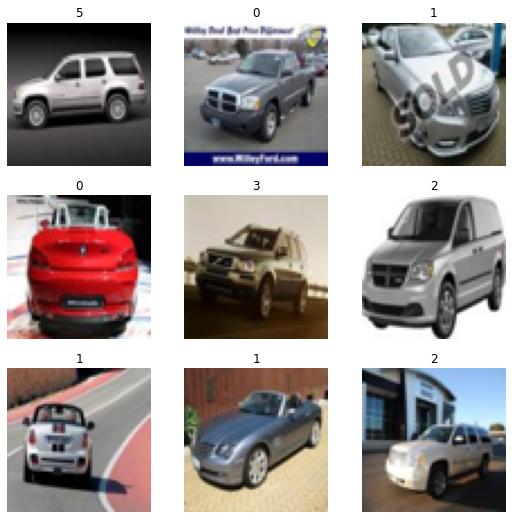

In [6]:
images, labels = load_dataset()
dls = make_dataloaders_from_numpy_data(images, labels)

# sanity check
dls.show_batch(cmap='gray')

## Conditional DDPM Training as a Callback

Same as DDPM callback but:
- We invert the x,y structure of the original callback
- Generates noise on the callback for the whole batch
- The sampling "before_batch_sampling" is done with labels that are fixed to [0,1,2,3,4...9,0,1,2,3....]

In [7]:
class ConditionalDDPMCallback(Callback):
    def __init__(self, n_steps, beta_min, beta_max, cfg_scale=0):
        store_attr()
        self.tensor_type=TensorImage

    def before_fit(self):
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps).to(self.dls.device) # variance schedule, linearly increased with timestep
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma = torch.sqrt(self.beta)
    
    def sample_timesteps(self, x, dtype=torch.long):
        return torch.randint(self.n_steps, (x.shape[0],), device=x.device, dtype=dtype)
    
    def generate_noise(self, x):
        return self.tensor_type(torch.randn_like(x))
    
    def noise_image(self, x, eps, t):
        alpha_bar_t = self.alpha_bar[t][:, None, None, None]
        return torch.sqrt(alpha_bar_t)*x + torch.sqrt(1-alpha_bar_t)*eps # noisify the image
    
    def before_batch_training(self):
        x0 = self.xb[0] # original images and labels
        y0 =  self.yb[0] if np.random.random() > 0.1 else None
        
        # y0 = None
        
        eps = self.generate_noise(x0) # noise same shape as x0
        t = self.sample_timesteps(x0) # select random timesteps
        xt = self.noise_image(x0, eps, t)  # add noise to the image
        # print(x0.shape, y0.shape, t.shape, xt.shape, eps.shape)
        
        self.learn.xb = (xt, t, y0) # input to our model is noisy image, timestep and label
        self.learn.yb = (eps,) # ground truth is the noise 

    def sampling_algo(self, xt, t, label=None):
        t_batch = torch.full((xt.shape[0],), t, device=xt.device, dtype=torch.long)
        z = self.generate_noise(xt) if t > 0 else torch.zeros_like(xt)
        alpha_t = self.alpha[t] # get noise level at current timestep
        alpha_bar_t = self.alpha_bar[t]
        sigma_t = self.sigma[t]
        alpha_bar_t_1 = self.alpha_bar[t-1]  if t > 0 else torch.tensor(1, device=xt.device)
        beta_bar_t = 1 - alpha_bar_t
        beta_bar_t_1 = 1 - alpha_bar_t_1
        predicted_noise = self.model(xt, t_batch, label=label)
        if self.cfg_scale>0:
            uncond_predicted_noise = self.model(xt, t_batch, label=None)
            predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, self.cfg_scale)
        x0hat = (xt - torch.sqrt(beta_bar_t) * predicted_noise)/torch.sqrt(alpha_bar_t)
        x0hat = torch.clamp(x0hat, -1, 1)
        xt = x0hat * torch.sqrt(alpha_bar_t_1)*(1-alpha_t)/beta_bar_t + xt * torch.sqrt(alpha_t)*beta_bar_t_1/beta_bar_t + sigma_t*z 

        return xt
    
    # def sampling_algo_old(self, xt, t, label=None):
    #     t_batch = torch.full((xt.shape[0],), t, device=xt.device, dtype=torch.long)
    #     z = self.generate_noise(xt) if t > 0 else torch.zeros_like(xt)
    #     alpha_t = self.alpha[t] # get noise level at current timestep
    #     alpha_bar_t = self.alpha_bar[t]
    #     sigma_t = self.sigma[t]
    #     xt = 1/torch.sqrt(alpha_t) * (xt - (1-alpha_t)/torch.sqrt(1-alpha_bar_t) * self.model(xt, t_batch, label=label)) + sigma_t*z 
    #          1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
    #     # predict x_(t-1) in accordance to Algorithm 2 in paper
    #     return xt    
   
    def sample(self):            
        xt = self.generate_noise(self.xb[0])  # a full batch at once!
        label = torch.arange(10, dtype=torch.long, device=xt.device).repeat(xt.shape[0] // 10 + 1).flatten()[
                0:xt.shape[0]]
        for t in progress_bar(reversed(range(self.n_steps)), total=self.n_steps, leave=False):
            xt = self.sampling_algo(xt, t, label)
        return xt
    
    def before_batch_sampling(self):
        xt = self.sample()
        self.learn.pred = (xt,)
        raise CancelBatchException
    
    def after_validate(self):
        if (self.epoch+1) % 4 == 0:
            with torch.no_grad():
                xt = self.sample()
                wandb.log({"preds": [wandb.Image(torch.tensor(im)) for im in xt[0:36]]})
    
    def before_batch(self):
        if not hasattr(self, 'gather_preds'): self.before_batch_training()
        else: self.before_batch_sampling()
    
    def get_sample(self, input_dim, label, embedding=None):
        if embedding is None:
            embedding = self.tensor_type(torch.randn(input_dim))
        embedding = embedding.to(device)
        for t in progress_bar(reversed(range(self.n_steps)), total=self.n_steps, leave=False):
            images = self.sampling_algo(embedding, t, label)

        return images, embedding
    
    def save(self, filepath):
        state = {
            'n_steps': self.n_steps,
            'beta_min': self.beta_min,
            "beta": self.beta,
            'beta_max': self.beta_max,
            'cfg_scale': self.cfg_scale,
            'alpha': self.alpha,
            "alpha_bar": self.alpha_bar,
            "sigma": self.sigma,
        }
        torch.save(state, filepath)

    def load(self, filepath):
        if device.type == "cpu":
            state = torch.load(filepath, map_location=torch.device('cpu'))
        else:
            state = torch.load(filepath)
        self.n_steps = state['n_steps']
        self.beta_min = state['beta_min']
        self.beta_max = state['beta_max']
        self.cfg_scale = state['cfg_scale']
        self.alpha = state['alpha']
        self.alpha_bar = state["alpha_bar"]
        self.sigma = state["sigma"]
        self.beta = state["beta"]

In [8]:
class EMA(Callback):
    "Exponential Moving average CB"
    def __init__(self, beta=0.995, pct_start=0.3):
        store_attr()
        
    def before_fit(self):
        self.ema_model = deepcopy(self.model).eval().requires_grad_(False)
        self.step_start_ema = int(self.pct_start*self.n_epoch)  #start EMA at 30% of epochs
        
    def update_model_average(self):
        for current_params, ma_params in zip(self.model.parameters(), self.ema_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self):
        if self.epoch < self.step_start_ema:
            self.reset_parameters()
            self.step += 1
            return
        self.update_model_average()
        self.step += 1

    def reset_parameters(self):
        self.ema_model.load_state_dict(self.model.state_dict())
    
    def after_batch(self):
        if hasattr(self, 'pred'): return
        self.step_ema()
    
    def after_training(self):
        self.model = self.ema_model

We have to add the conditioning to the Unet, to do so, we just subclass it and inject the encoded label on the `forward` pass.

In [9]:
@delegates(Unet)
class ConditionalUnet(Unet):
    def __init__(self, dim, num_classes=None, **kwargs):
        super().__init__(dim=dim, **kwargs)
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, dim * 4)
    
    def forward(self, x, time, label=None):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        if label is not None:
            t += self.label_emb(label)
            
        return super().forward_blocks(x, t)

Now we can create a fastai Learner with our DataLoaders, Callback (with the appropriate number of timesteps and noise schedule) and the simple MSE loss that we use to train DDPM.

In [10]:
import wandb
from fastai.callback.wandb import WandbCallback

In [11]:
model = ConditionalUnet(dim=IMG_SIZE, channels=3, num_classes=10).to(device)
ddpm_learner = Learner(dls, model, 
                       cbs=[ConditionalDDPMCallback(n_steps=1000, beta_min=0.0001, beta_max=0.02, cfg_scale=3),
                            EMA()], 
                       loss_func=nn.L1Loss())

Let's use fastai's amazing LR finder to select a good LR for training:

In [12]:
#ddpm_learner.lr_find()

And now let's train with one-cycle LR schedule:

In [13]:
wandb.init(project="ddpm_fastai", group="cifar10", tags=["fp", "ema"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: felix_krause1999. Use `wandb login --relogin` to force relogin


Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x14ddfdc85ed0>> (for post_execute):


ModuleNotFoundError: No module named 'jsonschema'

In [14]:
# Check if GPU is detected
if torch.cuda.is_available():
    print("Using GPU!")

Using GPU!


In [ ]:
# RUN TRAINING
epochs = 100
LR = 3e-5
ddpm_learner.fit_one_cycle(epochs, LR, cbs =[SaveModelCallback(monitor="train_loss", fname="cifar10"), 
                                               WandbCallback(log_preds=False, log_model=True)])

epoch,train_loss,valid_loss,time
0,0.842882,0.836391,00:17
1,0.834953,0.823046,00:12
2,0.826625,0.811146,00:12
3,0.818053,0.799230,04:12
4,0.808292,0.785398,00:12
5,0.797367,0.766928,00:12
6,0.784598,0.748916,00:12
7,0.768078,0.722749,04:12
8,0.748061,0.688123,00:12
9,0.722125,0.637364,00:12


Better model found at epoch 0 with train_loss value: 0.8428823947906494.
Better model found at epoch 1 with train_loss value: 0.8349531888961792.
Better model found at epoch 2 with train_loss value: 0.8266249299049377.


/localscratch/298346/ipykernel_1831467/3203114702.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wandb.log({"preds": [wandb.Image(torch.tensor(im)) for im in xt[0:36]]})


Better model found at epoch 3 with train_loss value: 0.8180528283119202.


wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 71 is less than current step: 72. Dropping entry: {'epoch': 4, '_timestamp': 1696540092.2896187}).
wandb: WARNING (User provided step: 71 is less than current step: 72. Dropping entry: {'valid_loss': 0.7992303371429443, '_timestamp': 1696540092.2897034}).


Better model found at epoch 4 with train_loss value: 0.8082922101020813.
Better model found at epoch 5 with train_loss value: 0.7973671555519104.
Better model found at epoch 6 with train_loss value: 0.7845979928970337.


Better model found at epoch 7 with train_loss value: 0.7680778503417969.


wandb: WARNING (User provided step: 143 is less than current step: 144. Dropping entry: {'epoch': 8, '_timestamp': 1696540383.0446146}).
wandb: WARNING (User provided step: 143 is less than current step: 144. Dropping entry: {'valid_loss': 0.7227493524551392, '_timestamp': 1696540383.044701}).


Better model found at epoch 8 with train_loss value: 0.748060941696167.
Better model found at epoch 9 with train_loss value: 0.7221253514289856.
Better model found at epoch 10 with train_loss value: 0.6892966032028198.


Better model found at epoch 11 with train_loss value: 0.6489880681037903.


wandb: WARNING (User provided step: 215 is less than current step: 216. Dropping entry: {'epoch': 12, '_timestamp': 1696540673.5833054}).
wandb: WARNING (User provided step: 215 is less than current step: 216. Dropping entry: {'valid_loss': 0.5303623676300049, '_timestamp': 1696540673.583406}).


Better model found at epoch 12 with train_loss value: 0.6011406183242798.
Better model found at epoch 13 with train_loss value: 0.5492932796478271.
Better model found at epoch 14 with train_loss value: 0.4956866502761841.


Better model found at epoch 15 with train_loss value: 0.44440916180610657.
Better model found at epoch 16 with train_loss value: 0.4000130593776703.


wandb: WARNING (User provided step: 287 is less than current step: 288. Dropping entry: {'epoch': 16, '_timestamp': 1696540964.3883612}).
wandb: WARNING (User provided step: 287 is less than current step: 288. Dropping entry: {'valid_loss': 0.30632147192955017, '_timestamp': 1696540964.388451}).


Better model found at epoch 17 with train_loss value: 0.3628288209438324.
Better model found at epoch 18 with train_loss value: 0.3329799771308899.


Better model found at epoch 19 with train_loss value: 0.3072650134563446.


wandb: WARNING (User provided step: 359 is less than current step: 360. Dropping entry: {'epoch': 20, '_timestamp': 1696541255.384889}).
wandb: WARNING (User provided step: 359 is less than current step: 360. Dropping entry: {'valid_loss': 0.24370776116847992, '_timestamp': 1696541255.3849754}).


Better model found at epoch 20 with train_loss value: 0.2862969636917114.
Better model found at epoch 21 with train_loss value: 0.2691648006439209.
Better model found at epoch 22 with train_loss value: 0.25380364060401917.


Better model found at epoch 23 with train_loss value: 0.24251097440719604.


wandb: WARNING (User provided step: 431 is less than current step: 432. Dropping entry: {'epoch': 24, '_timestamp': 1696541545.9102125}).
wandb: WARNING (User provided step: 431 is less than current step: 432. Dropping entry: {'valid_loss': 0.22214044630527496, '_timestamp': 1696541545.9103012}).


Better model found at epoch 24 with train_loss value: 0.23212644457817078.
Better model found at epoch 25 with train_loss value: 0.22109444439411163.
Better model found at epoch 26 with train_loss value: 0.21459947526454926.


Better model found at epoch 27 with train_loss value: 0.20841290056705475.
Better model found at epoch 28 with train_loss value: 0.2029230296611786.


wandb: WARNING (User provided step: 503 is less than current step: 504. Dropping entry: {'epoch': 28, '_timestamp': 1696541836.5251477}).
wandb: WARNING (User provided step: 503 is less than current step: 504. Dropping entry: {'valid_loss': 0.187973752617836, '_timestamp': 1696541836.5252333}).


Better model found at epoch 29 with train_loss value: 0.1974789798259735.
Better model found at epoch 30 with train_loss value: 0.19164392352104187.


Better model found at epoch 31 with train_loss value: 0.18572375178337097.


wandb: WARNING (User provided step: 575 is less than current step: 576. Dropping entry: {'epoch': 32, '_timestamp': 1696542127.3152127}).
wandb: WARNING (User provided step: 575 is less than current step: 576. Dropping entry: {'valid_loss': 0.1710653007030487, '_timestamp': 1696542127.315298}).


Better model found at epoch 32 with train_loss value: 0.18180358409881592.
Better model found at epoch 33 with train_loss value: 0.17685353755950928.
Better model found at epoch 34 with train_loss value: 0.17366184294223785.


Better model found at epoch 35 with train_loss value: 0.1707177460193634.


wandb: WARNING (User provided step: 647 is less than current step: 648. Dropping entry: {'epoch': 36, '_timestamp': 1696542417.3777108}).
wandb: WARNING (User provided step: 647 is less than current step: 648. Dropping entry: {'valid_loss': 0.16659347712993622, '_timestamp': 1696542417.3778052}).


Better model found at epoch 36 with train_loss value: 0.16867467761039734.
Better model found at epoch 37 with train_loss value: 0.16561472415924072.
Better model found at epoch 38 with train_loss value: 0.16321946680545807.


Better model found at epoch 39 with train_loss value: 0.1610654592514038.


wandb: WARNING (User provided step: 719 is less than current step: 720. Dropping entry: {'epoch': 40, '_timestamp': 1696542708.229184}).
wandb: WARNING (User provided step: 719 is less than current step: 720. Dropping entry: {'valid_loss': 0.15439818799495697, '_timestamp': 1696542708.2292686}).


Better model found at epoch 40 with train_loss value: 0.1595863699913025.
Better model found at epoch 41 with train_loss value: 0.1571965515613556.


In [ ]:
ddpm_learner.recorder.plot_loss()

## Save model

In [ ]:
learner_name = "learner_v3"
callback_name = "callback_v3"

In [ ]:
# Save the entire Learner, including model and callbacks
ddpm_learner.save(learner_name)

callback = ddpm_learner.conditional_ddpm
callback.save(f'output/{callback_name}.pth')

In [ ]:
# STOP HERE WITH RUN ALL
raise Exception("stop")

In [ ]:
# Create a new instance of the ConditionalDDPMCallback and load its state
loaded_callback = ConditionalDDPMCallback(n_steps=0, beta_min=0, beta_max=0, cfg_scale=0)
loaded_callback.load(f'output/{callback_name}.pth')

# Load the Learner from the saved file
ddpm_learner = Learner(dls, model, 
                       cbs=[loaded_callback,
                            EMA()],
                       loss_func=nn.L1Loss())

ddpm_learner.load(learner_name, device=None, with_opt=True, strict=True)

# Replace the original callback with the loaded one
#loaded_learner.cbs = [loaded_callback, EMA()]

## Sample generation (FAULTY)

In [ ]:
nr_images = 1
class_label = 2
pred_image, embedding = ddpm_learner.conditional_ddpm.get_sample((nr_images, 3, IMG_SIZE, IMG_SIZE), torch.tensor(class_label).to(device))

In [ ]:
# plot prediction
img_nr = 0
#if device == "cuda":
pred_image = pred_image.cpu()
plt.imshow(pred_image[img_nr].permute(1,2,0).detach().numpy())
plt.show()

In [ ]:
# plot prediction
img_nr = 0
#if device == "cuda":
embedding = embedding.cpu()
plt.imshow(embedding[0].permute(1,2,0).detach().numpy())
plt.show()

## OLD Sample generation (WORKING BUT SLOW AF)

Since we implemented sampling in the Callback, we simply can call fastai's built-in `get_preds` function to get our predictions.

In [ ]:
ddpm_learner.get_preds()